<a href="https://colab.research.google.com/github/EstherWhang/jpm_changepoint/blob/main/testing_algs/pydata_gen_ruptures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pydata generators vs Ruptures detectors


Testing pydata generators against ruptures changepoint detection algorithms.


In [1]:
%matplotlib inline
import math
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import copy
import random

## Generators

In [12]:
class Generator(object):
    
    def __init__(self):
        self._changepoint = -1
    
    def get(self):
        self._changepoint += 1
        return 1.0
    
class DistributionGenerator(Generator):
    """
    A generator which generates values from a single distribution. This may not immediately
    appear useful for change detection, however if we can model our unchanged data stream
    as a distribution then we can test against false positives by running tests against
    a single distribution.
    
    dist1:  A scipy.stats distribution for before changepoint.
    kwargs: The keyword arguments are passed to the distribution.
    """
    
    def __init__(self, dist, **kwargs):
        self._dist = dist
        self._args = kwargs
        
    def get(self):
        return self._dist.rvs(**self._args)

    
class ChangingDistributionGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then switches to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        
    def get(self):
        self._position += 1
        if self._position <= self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        else:
            return self._dist2.rvs(**self._kwargs2)

        
class DriftGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then drifts to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    steps:       The number of time steps to spend drifting to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint, steps):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        self._steps = steps
        
        #shifts to the new distribution
        self._change_gradient = np.linspace(0, 1, self._steps)
        
    def get(self):
        self._position += 1
        if self._position < self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        #if we haven't passed the gradient yet
        if self._position >= self._changepoint and self._position < self._changepoint + self._steps:
            #evaluate the gradient value
            beta = self._change_gradient[self._position - self._changepoint ]
            return ((1 - beta) * self._dist1.rvs(**self._kwargs1)) + (beta * self._dist2.rvs(**self._kwargs2))
        else:
            return self._dist2.rvs(**self._kwargs2)

## Creating dataset levels


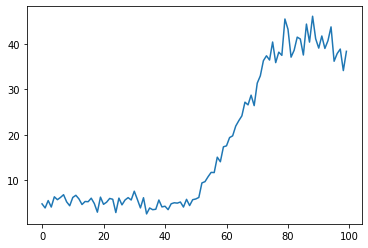

In [45]:
# easy data 
n = 100
gen_easy = DriftGenerator(stats.norm, {'loc': 5, 'scale':1}, stats.norm, {'loc':40, 'scale': 3}, 50, 30)
vals_easy = np.zeros(n)
for i in range(n):
    vals_easy[i] = gen_easy.get()
    
plt.plot(vals_easy)

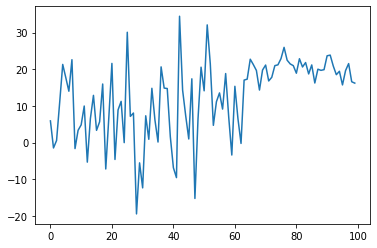

In [46]:
#medium data
n = 100
gen_med = DriftGenerator(stats.norm, {'loc': 5, 'scale':10}, stats.norm, {'loc':20, 'scale':3}, 50, 30)
vals_med = np.zeros(n)
for i in range(n):
    vals_med[i] = gen_med.get()
    
plt.plot(vals_med)

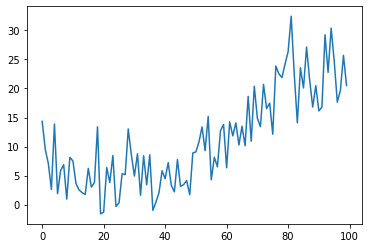

In [47]:
#hard data
n = 100
gen_hard = DriftGenerator(stats.norm, {'loc': 5, 'scale':5}, stats.norm, {'loc':20, 'scale':5}, 50, 30)
vals_hard = np.zeros(n)
for i in range(n):
    vals_hard[i] = gen_hard.get()
    
plt.plot(vals_hard)

In [16]:
!pip install ruptures
import ruptures as rpt  # our package

     |████████████████████████████████| 918 kB 5.0 MB/s 


# Applying Ruptures

### Binary seg

Result for Bin Seg:  [60, 100]


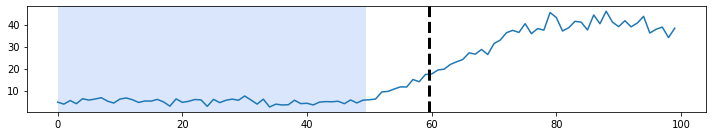

Result for Bin Seg:  [65, 100]


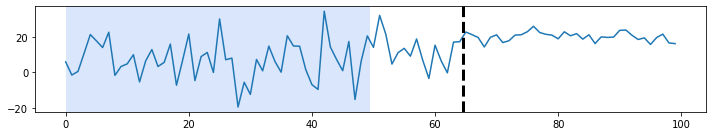

Result for Bin Seg:  [65, 100]


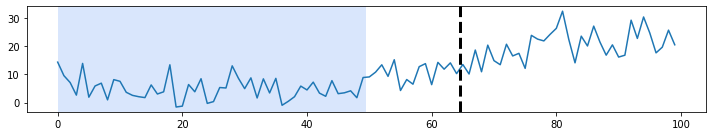

In [52]:
# n = 100
# gen_easy = DriftGenerator(stats.norm, {'loc': 5, 'scale':1}, stats.norm, {'loc':40, 'scale': 3}, 50, 30)
# signal = np.zeros(n)
# for i in range(n):
#     vals_easy[i] = gen_easy.get()

#easy data
n_bkps = 1
model = "rbf"  # "l1", "rbf", "linear", "normal", "ar",...
algo_bin = rpt.Binseg(model=model).fit(vals_easy)
result1 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result1 )
rpt.display(vals_easy, [50], result1)
plt.show()

#medium data
algo_bin = rpt.Binseg(model=model).fit(vals_med)
result2 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result2 )
rpt.display(vals_med, [50], result2)
plt.show()

#hard data
algo_bin = rpt.Binseg(model=model).fit(vals_hard)
result3 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result3 )
rpt.display(vals_hard, [50], result3)
plt.show()

### Bottom up 

Result for Bin Seg:  [55, 100]


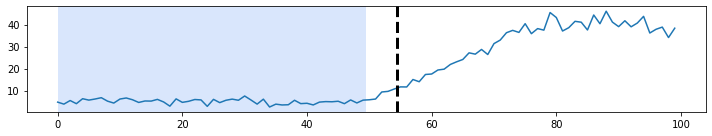

Result for Bin Seg:  [65, 100]


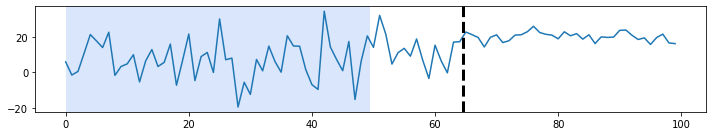

Result for Bin Seg:  [50, 100]


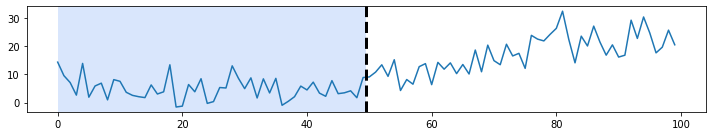

In [53]:
#easy data
n_bkps = 1
model = "rbf"  # "l1", "rbf", "linear", "normal", "ar",...
algo_bin = rpt.BottomUp(model=model).fit(vals_easy)
result1 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result1 )
rpt.display(vals_easy, [50], result1)
plt.show()

#medium data
algo_bin = rpt.BottomUp(model=model).fit(vals_med)
result2 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result2 )
rpt.display(vals_med, [50], result2)
plt.show()

#hard data
algo_bin = rpt.BottomUp(model=model).fit(vals_hard)
result3 = algo_bin.predict(n_bkps=1)

# print("Piecewise constant data: --------------------------------------")
print("Result for Bin Seg: ", result3 )
rpt.display(vals_hard, [50], result3)
plt.show()